# 决策树

本文是从scikit-learn官网中, 介绍决策树的相关文档整合而来.

Reference:
- [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)
- [Example of Decision Tree](https://scikit-learn.org/stable/auto_examples/index.html#decision-trees)

本文中用到的库导入如下.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

np.random.seed(0)  # set seed
np.set_printoptions (precision=3, suppress=True, linewidth=np.inf)  # set print format

## 决策树回归

决策树最初为分类模型而设计, 但是它也可以用于回归. 用于回归任务时, 每一个叶子节点上取一样的值, 这决定了决策树回归得到的是分段线性函数.

下面以单变量回归问题为例, 简要说明决策树回归的过程. 先如图所示, 生成数据

$$
y = \sin(x) + \sin(\frac{10x}{3})+\varepsilon.
$$

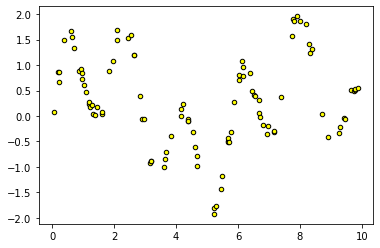

In [2]:
num_samples = 100
def func(x):
    return np.sin(x) + np.sin(10 / 3 * x) + np.random.normal(0, 0.1, size=x.shape)

x = np.sort(np.random.rand(num_samples, 1) * 10, axis=0)
x_input = x.reshape(num_samples, 1)
y = func(x)
plt.scatter(x, y, s=20, edgecolor='black', c='yellow', label='data')

下面给出了一个用五层决策树回归拟合数据的模型, 它大致捕捉了数据的变化特征. 可以明显地看出, 它是分段线性的, 并且每一段上是常数取值(除分界外).

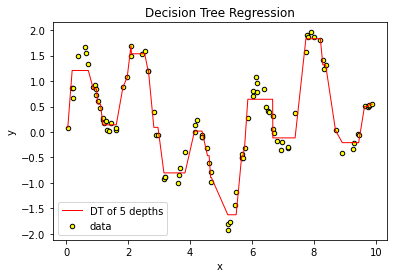

In [3]:
clf = DecisionTreeRegressor(max_depth=5).fit(x_input, y)
pred_y = clf.predict(x_input)

plt.figure()
plt.plot(x, pred_y, c='red', label='DT of 5 depths', linewidth=1)
plt.scatter(x, y, s=20, edgecolor='black', c='yellow', label='data')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

通过调整`max_depth`参数, 观察决策树是怎样一层一层生长的. 每加深一层, 原本层的一个水平分段就会被分成一个"阶梯", 从而慢慢地得到一个分段线性函数.

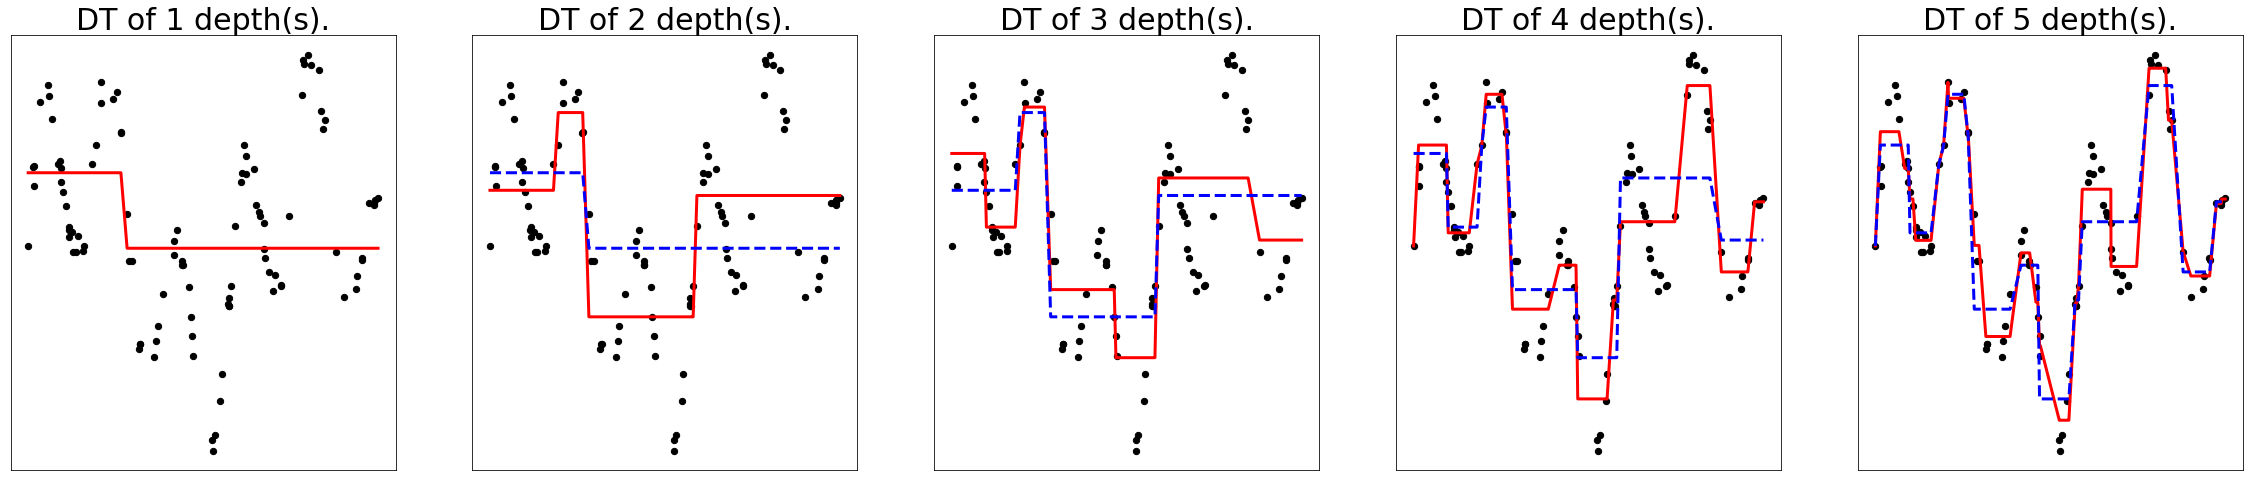

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(40, 8))
last_clf = None

for i in range(len(ax)):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    
    clf = DecisionTreeRegressor(max_depth=i+1).fit(x_input, y)
    pred_y = clf.predict(x_input)
    ax[i].scatter(x, y, s=40, c='black')
    ax[i].plot(x, pred_y, c='red', linewidth=3)
    if i:
        last_pred_y = last_clf.predict(x_input)
        ax[i].plot(x, last_pred_y, linestyle='dashed', linewidth=3, c='blue')
    ax[i].set_title('DT of {} depth(s).'.format(i+1), fontsize=30)
    last_clf = clf
    
plt.show()

## 树的可视化

先创建一个异或分类数据集.

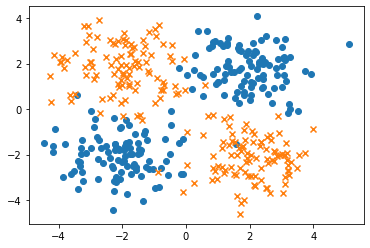

In [5]:
cov = [[1, 0], [0, 1]]
mean = [[2, 2], [-2, 2], [2, -2], [-2, -2]]

x = []
for i in range(4):
    x.append(np.random.multivariate_normal(mean=mean[i], cov=cov, size=100))
x = np.concatenate(x, axis=0)
y = np.repeat([1, -1, -1, 1], 100)
pos_index = (y == 1)
neg_index = (y == -1)

plt.scatter(x[pos_index, 0], x[pos_index, 1], marker='o', c='C0')
plt.scatter(x[neg_index, 0], x[neg_index, 1], marker='x', c='C1')
plt.show()

用决策树构造一个分类器, 选择最大深度为3.

In [6]:
clf = DecisionTreeClassifier(max_depth=3).fit(x, y)
print(clf.score(x, y))

0.555


由于分类问题定义在二维空间上, 可以绘制其决策边界. 浅层决策树在异或问题上的表现很差. 这是因为它难以找到第一次分叉的阈值.

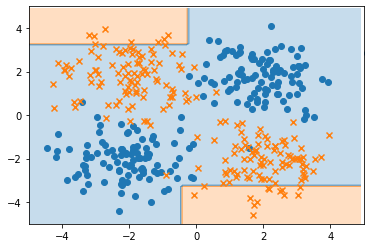

In [7]:
x_grid = np.arange(-5, 5, 0.1)
y_grid = np.arange(-5, 5, 0.1)
x_, y_ = np.meshgrid(x_grid, y_grid)
grid_input = np.vstack((x_.reshape(-1), y_.reshape(-1))).T
grid_output = clf.predict(grid_input)

cmap = ListedColormap(['C1', 'C0'])
plt.figure()
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.contourf(x_, y_, grid_output.reshape(x_.shape), cmap=cmap, alpha=0.25)
plt.scatter(x[pos_index, 0], x[pos_index, 1], marker='o', c='C0')
plt.scatter(x[neg_index, 0], x[neg_index, 1], marker='x', c='C1')
plt.show()

对维度更多的分类数据集, 决策边界难以绘制, 但可以用树形结构直观地表示.

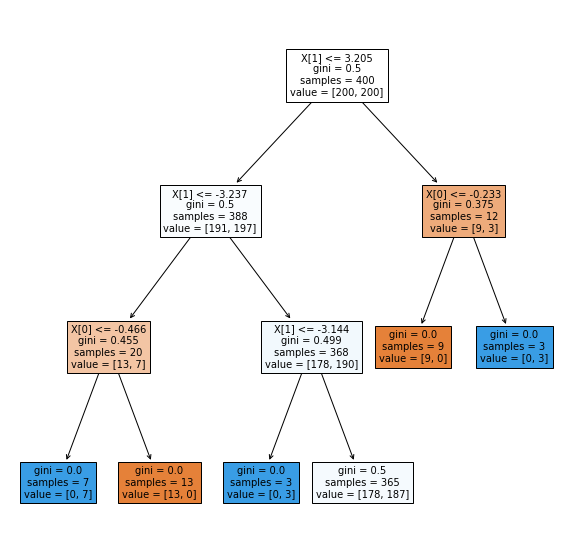

In [8]:
plt.figure(figsize=(10, 10))
plot_tree(clf, filled=True, max_depth=3)
plt.show()

通过分类器的`tree_`属性, 可以更全面地输出决策树的结构信息. 此属性是`Tree`实例, 它是决策树的二叉树组表示, 下面是与决策树结构相关的主要属性, 其中以数组索引形式表示的属性本身是一个数组, 数组的每一个索引代表列表值.

- `node_count`: 节点数.
- `max_depth`: 最大深度.
- `children_left[i]`: 节点 $i$ 的左孩子.
- `children_right[i]`: 节点 $i$ 的右孩子.
- `feature[i]`: 节点 $i$ 用于分类的特征.
- `threshold[i]`: 节点 $i$ 用于分类的阈值. 定义左孩子为`feature[i] <= threshold[i]`的节点, 右孩子为`feature[i] > threshold[i]`的节点.
- `value[i], impurity[i]`: 节点 $i$ 的分类结果与杂质程度.

In [9]:
tree = clf.tree_

print('Number of nodes: {}'.format(tree.node_count))
print('Max depths: {}'.format(tree.max_depth))
print('Left Children: {}'.format(tree.children_left))
print('Right Children: {}'.format(tree.children_right))
print('feature: {}'. format(tree.feature))
print('threshold: {}'.format(tree.threshold))

Number of nodes: 11
Max depths: 3
Left Children: [ 1  2  3 -1 -1  6 -1 -1  9 -1 -1]
Right Children: [ 8  5  4 -1 -1  7 -1 -1 10 -1 -1]
feature: [ 1  1  0 -2 -2  1 -2 -2  0 -2 -2]
threshold: [ 3.205 -3.237 -0.466 -2.    -2.    -3.144 -2.    -2.    -0.233 -2.    -2.   ]


上面的代码给出了决策树结构的相关具体值, 下面的代码递归地给出了决策树的直观结构.

In [10]:
def print_tree_struct(node, level, condition, tree, wrong=0):
    """print the structure of given DT."""
    pre_wrong = wrong
    
    if level == 0:
        print('Begin Visualize DT:')
        print()
    if condition:
        assert level >= 1
        print('\t' * (level - 1) + condition)
    print('\t' * level + 'Node: {}, Level: {}'.format(node, level))
    print('\t' * level + 'Classification result: {}'.format(tree.value[node]))
    
    if tree.feature[node] >= 0:  # not leaf
        print('\t' * level + 'Feature: x[{}], Threshold: {:.3f}'.format(tree.feature[node], tree.threshold[node]))
    else:
        wrong += (tree.value[node]).min()
        return wrong
    
    if tree.children_left[node] >= 0:
        print('-'*(20 + 8*level))
        cond_left = 'If x[{}] < {:.3f}:'.format(tree.feature[node], tree.threshold[node])
        wrong += print_tree_struct(tree.children_left[node], level+1, cond_left, tree, pre_wrong)
    if tree.children_right[node] > 0:
        print()
        cond_right = 'If x[{}] < {:.3f}:'.format(tree.feature[node], tree.threshold[node])
        wrong += print_tree_struct(tree.children_right[node], level+1, cond_right, tree, pre_wrong)
    
    if level == 0:
        print('-'*80)
        print('Total wrong: {},\nMisclassification Rate: {}.'.format(wrong, wrong / tree.value[node].sum()))
    return wrong

wrong = print_tree_struct(0, 0, None, tree)

Begin Visualize DT:

Node: 0, Level: 0
Classification result: [[200. 200.]]
Feature: x[1], Threshold: 3.205
--------------------
If x[1] < 3.205:
	Node: 1, Level: 1
	Classification result: [[191. 197.]]
	Feature: x[1], Threshold: -3.237
----------------------------
	If x[1] < -3.237:
		Node: 2, Level: 2
		Classification result: [[13.  7.]]
		Feature: x[0], Threshold: -0.466
------------------------------------
		If x[0] < -0.466:
			Node: 3, Level: 3
			Classification result: [[0. 7.]]

		If x[0] < -0.466:
			Node: 4, Level: 3
			Classification result: [[13.  0.]]

	If x[1] < -3.237:
		Node: 5, Level: 2
		Classification result: [[178. 190.]]
		Feature: x[1], Threshold: -3.144
------------------------------------
		If x[1] < -3.144:
			Node: 6, Level: 3
			Classification result: [[0. 3.]]

		If x[1] < -3.144:
			Node: 7, Level: 3
			Classification result: [[178. 187.]]

If x[1] < 3.205:
	Node: 8, Level: 1
	Classification result: [[9. 3.]]
	Feature: x[0], Threshold: -0.233
--------------

## 剪枝

### 后剪枝

对决策树 $T$, 定义其总误分率为 $R(T)$, 那么决定是否剪枝的成本复杂度度量 $R_\alpha(T)$ 定义为

$$
R_\alpha(T) = R(T) + \alpha|\tilde{T}|,
$$

其中, $\alpha > 0$ 是预先设定的复杂度超参数, $|\tilde{T}|$ 是决策树 $T$ 所含的终端节点数量.

对单个节点 $t$, 定义其成本复杂度为 $R_\alpha(t)=R(t)+\alpha$. 定义 $T_t$ 为以 $t$ 为根节点的子决策树, 一般成立

$$
R(T_t) < R(t),
$$

这意味着继续分割一般总能提高决策树在训练集上的准确率. 但是选择合适的超参数值 $\alpha$ 能使得

$$
R_\alpha(T_t) = R_\alpha(t) \implies \alpha = \frac{R(t)-R(T_t)}{|\tilde{T}_t|-1},
$$

将此 $\alpha$ 定义为节点 $t$ 的有效 $\alpha$, 记作 $\alpha_\text{eff}(t)$. 在决策树中, 通过设定`ccp_alpha`值剪枝, 如果存在 $t$ 使得 $\alpha_\text{eff}(t)$ 不大于`ccp_alpha`, 就将此枝剪下.

`load_breast_cancer()`函数加载一个二分类数据集. 在下面的代码中, 通过调整`ccp_alpha`的值, 观察训练集和测试集准确率的变化.

In [11]:
data, target = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

train_acc = []
test_acc = []
ccp_alphas = np.arange(0, 0.1, 0.001)

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha).fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

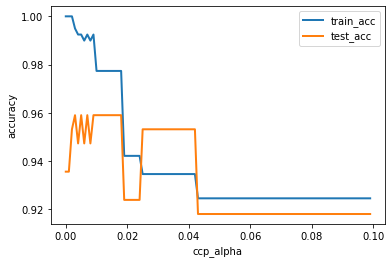

In [12]:
plt.plot(ccp_alphas, train_acc, c='C0', linewidth=2, label='train_acc')
plt.plot(ccp_alphas, test_acc, c='C1', linewidth=2, label='test_acc')
plt.legend()
plt.xlabel('ccp_alpha'); plt.ylabel('accuracy')
plt.show()

### 前剪枝

后剪枝是对树完全生长后进行剪枝, 也可以选择在树的生长过程中进行剪枝, 即前剪枝.

在决策树中, `max_depth`, `min_samples_split`, `min_samples_leaf`可用于控制前剪枝, 它们的作用分别如下:

- `max_depth`: 指定树的最大深度. 如果设置为`None`且没有其他前剪枝准则, 则生长到所有叶子都是纯的为止.
- `min_samples_split`: 指定拆分内部节点所需的最小样本数. 可以设置为`int`型或`float`型. 如果设置为`float`型, 则被视为分数, 此时`min_samples_split=ceil(min_samples_split * n_samples)`.
- `min_samples_leaf`: 指定叶子节点所需的最小样本数.
- `mix_impurity_decrease`: 只有节点的杂质减少大于这个值, 节点才会被分割. 杂质的减少定义为
  
  $$
  \frac{N_t}{N}\left(\text{Impurity}-\frac{N_t^R}{N_t}\text{Impurity}^R-\frac{N_t^L}{N_t}\text{LeftImpurity}^L \right).
  $$
  
  其中 $N$ 是总样本量, $N_t$ 是节点 $t$ 中的样本量.

关于`min_samples_split`和`min_samples_leaf`的区别, 主要在于`min_samples_leaf`的分割需要保证两个子节点都至少有一定的样本数量, 而`min_samples_split`只需要保证有至少一个子节点有一定的样本数量.